<h3>The purpose of this code is to normalise the linear theory Power Spectrum(PS) found from the primordial power spectrum evolved using a Transfer Function(TF). </h3>
<ul>
<li>The TF is sourced from Niladri's dataset [source file address: ./../Data/Transfer_camb_su_1024.txt]<br>
<li>Growth factor assumed is G(a) = a = 1/(1+z) | z=0 <br>
<li>The Normalization is done by comparing the sigma_8 value to the current (z=0). <br>
Sigma_8 is the variance in density perturbations smoothed over a scale of R=8 h^-1 MPc. <br>
(Detailed reference to using Top-Hat/Gaussian filter can be seen from Cooray & Sheth page 10) <br>
<li> Integration to be done using logarithmic spacing
<li>Cosmology in consideration is as follows:
omega_m = 0.276, omega_b = 0.045, h= 0.7, sigma_8 = 0.811, ns = 0.961 
</ul>

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

R=8  # MPc h^-1

'''
#WMAP1 Cosmology
sigma_8=0.9  # WMAP1 Cosmology
ns=0.99  # WMAP1 Cosmology
h=0.72  # 100h km/s MPc is the Hubble's Constant Today
'''
#Niladri Cosmology
sigma_8=0.811
ns=0.961
h=0.7

def TopHat(k,R):
    return (3/np.power(k*R,3))*(np.sin(k*R)-(k*R)*np.cos(k*R))

def Gaussian(k,R):
    return np.exp(np.power((k*R),2)/-2.0)

In [24]:
path="./../Data/"
fname="Transfer_camb_su_1024.txt"
#fname="Transfer_tinker-2005.txt"
data=np.loadtxt(path+fname)
k=np.array(data[:,0])
T_k=np.array(data[:,1])

(-6, 2)

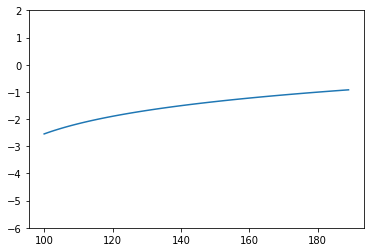

In [37]:
x=np.log(k)
y=np.arange(len(k))
plt.plot(y[100:190],x[100:190])
plt.ylim(-6,2)

In [82]:
logk=np.log10(k)

top=TopHat(k,R)
gaus=Gaussian(k,R)

res1=np.power(T_k,2)*np.power(k,2+ns)   # Tf^2 x k^3
res2=res1*(top**2)  # f1(k)=Tf^2 x k^(3+n) x W(kR)^2 (topHat)
res3=res1*(gaus**2)  # f2(k)=" " " " " " W(kR)^2 (Gaussian)

ansTop=np.trapz(res2,k)
ansGaus=np.trapz(res3,k)

#AT=sigma_8**2*(2*np.pi**2)/ansTop
AT=2*(np.pi**2)*(sigma_8**2)/ansTop   #### Problem of missing factor of 2(Pi)
#AG=np.power(sigma_8,2)/(4*np.pi*ansGaus)
AG=(sigma_8**2)*np.pi/ansGaus


print(AT)
print(AG)

2.439839701274657e-08
1.0740994299996582e-08


In [83]:
P_k_T=AT*np.power(k,ns)*np.power(T_k,2)
D_k_T=(np.power(k,3)*P_k_T)/(2*(np.pi**2))
#D_k=(np.power(k,3)*P_k)

P_k_G=AG*np.power(k,ns)*np.power(T_k,2)
D_k_G=(np.power(k,3)*P_k_G)/(2*(np.pi**2))

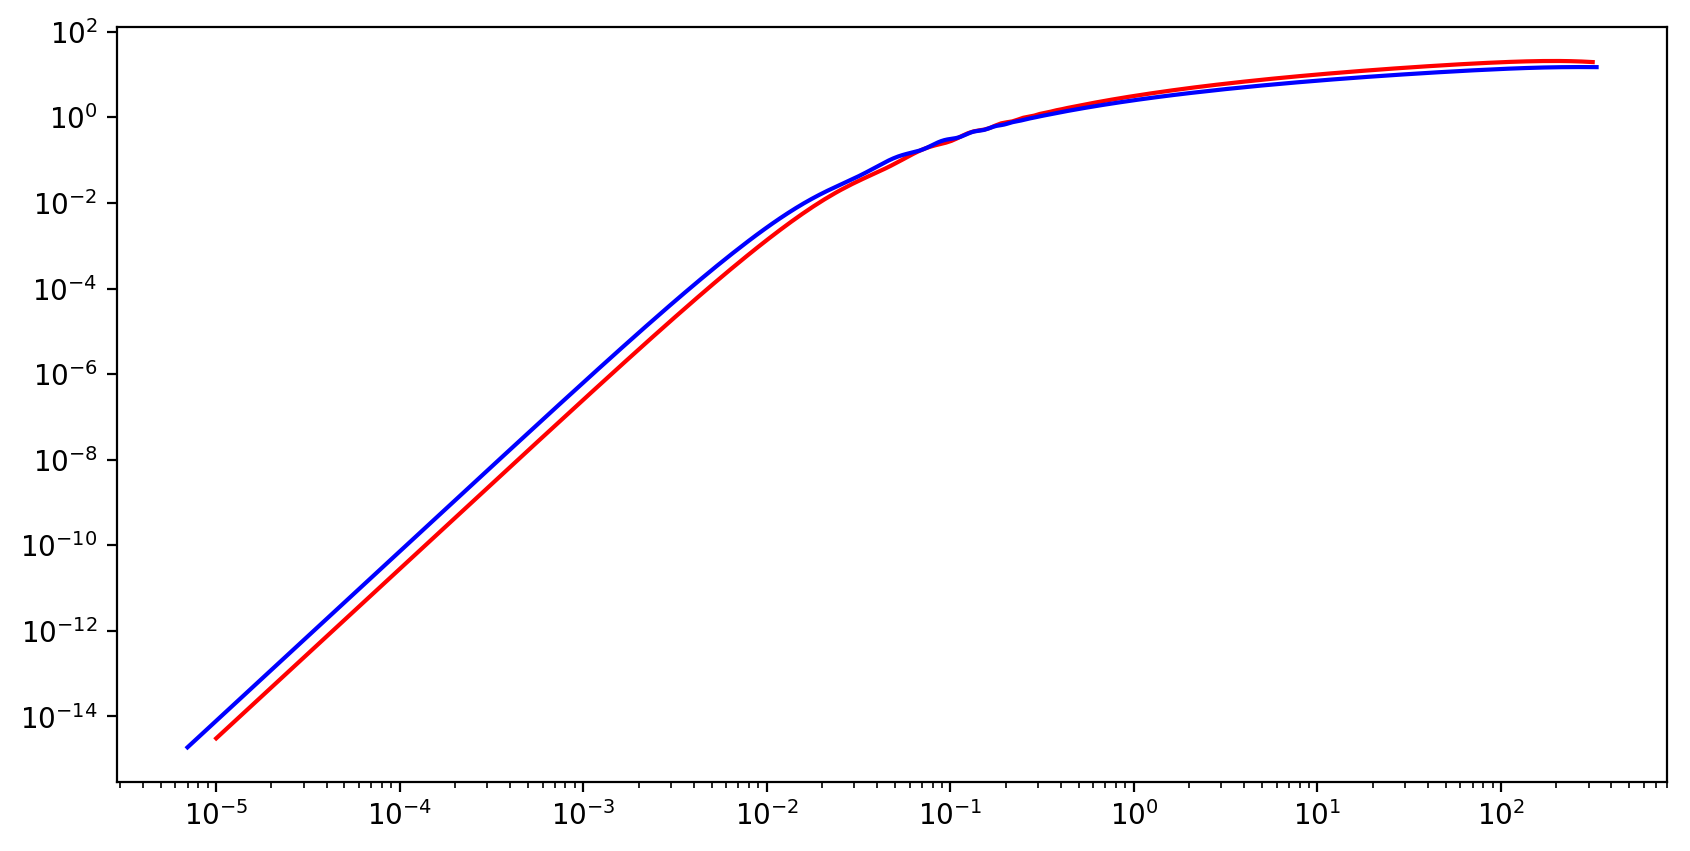

In [84]:
data2=np.loadtxt("./../Data/power_spectrum_camb_su1024_cosmology.txt")
plt.figure(figsize=(10,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(data2[:,0],data2[:,1],color="r")
plt.plot(k,D_k_T,color="b")
#plt.plot(k,D_k_G,color="g")
plt.yscale("log")
plt.xscale("log")
plt.show()

In [12]:
k=np.array(k)
D_k=np.array(D_k_T)
dumpster=[k,D_k]
pickle.dump(dumpster,open('NormalizedDimensionlessPS.p','wb'))
with open('NormalizedDimensionlessPS.txt','w') as f:
    f.write('# WMAP1 Cosmology normalised linear theory Power Spectrum (Dimensionless)\n')
    f.write('# k   D_k\n')
    for i in range(0,len(k)):
        f.write(str(k[i])+"\t"+str(D_k[i])+"\n")